<a href="https://colab.research.google.com/github/ayten21/Tensorflow/blob/main/Transfer_Learning_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Aug 22 12:31:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
import zipfile
import os
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-08-22 12:31:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   240MB/s    in 0.7s    

2022-08-22 12:31:02 (240 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [4]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')
print('Testing images:')
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size = IMAGE_SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [14]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [7]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
def create_model(model_url, num_classes = 10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = 'feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE + (3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])
  return model

In [11]:
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [15]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220822-124052
Epoch 1/5
24/24 [==============================] - 33s 796ms/step - loss: 1.8848 - accuracy: 0.3880 - val_loss: 1.2173 - val_accuracy: 0.6164
Epoch 2/5
24/24 [==============================] - 16s 684ms/step - loss: 0.9119 - accuracy: 0.7240 - val_loss: 0.8651 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 16s 697ms/step - loss: 0.6244 - accuracy: 0.8267 - val_loss: 0.7716 - val_accuracy: 0.7516
Epoch 4/5
24/24 [==============================] - 18s 791ms/step - loss: 0.4857 - accuracy: 0.8693 - val_loss: 0.7167 - val_accuracy: 0.7672
Epoch 5/5
24/24 [==============================] - 17s 723ms/step - loss: 0.3888 - accuracy: 0.9067 - val_loss: 0.6943 - val_accuracy: 0.7708


In [24]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss, label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

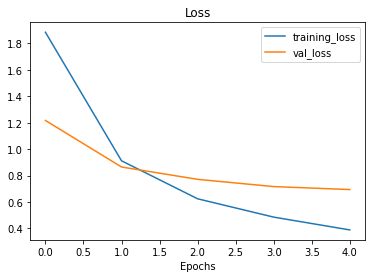

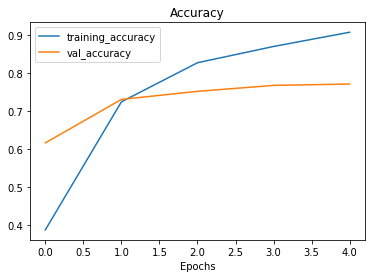

In [25]:
plot_loss_curves(resnet_history)

In [26]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [28]:
efficientnet_model = create_model(model_url=efficientnet_url, 
                                  num_classes=train_data_10_percent.num_classes)
efficientnet_model.compile(loss ='categorical_crossentropy',
                                 optimizer = tf.keras.optimizers.Adam(),
                                 metrics = ['accuracy'])
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub', 
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220822-125717
Epoch 1/5
24/24 [==============================] - 28s 775ms/step - loss: 1.8369 - accuracy: 0.4493 - val_loss: 1.2871 - val_accuracy: 0.7212
Epoch 2/5
24/24 [==============================] - 16s 684ms/step - loss: 1.0490 - accuracy: 0.7813 - val_loss: 0.8700 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 17s 743ms/step - loss: 0.7519 - accuracy: 0.8360 - val_loss: 0.6992 - val_accuracy: 0.8428
Epoch 4/5
24/24 [==============================] - 15s 645ms/step - loss: 0.6004 - accuracy: 0.8773 - val_loss: 0.6120 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 16s 679ms/step - loss: 0.5069 - accuracy: 0.9000 - val_loss: 0.5610 - val_accuracy: 0.8620


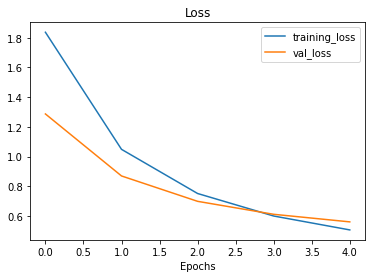

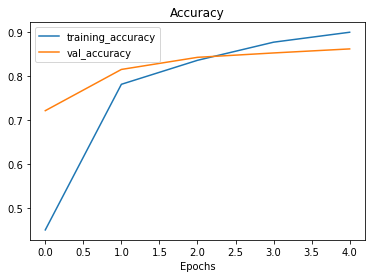

In [29]:
plot_loss_curves(efficientnet_history)

In [30]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [34]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=hED90WlSZR8IqlzyfljFDuvoyFKfOK&prompt=consent&access_type=off

In [35]:
!tensorboard dev list

https://tensorboard.dev/experiment/09500RnnTBaArno0wMc7Jw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   09500RnnTBaArno0wMc7Jw
	Created              2022-08-22 13:11:05 (3 minutes ago)
	Updated              2022-08-22 13:11:08 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5922281
Total: 1 experiment(s)
